<a href="https://colab.research.google.com/github/ua-datalab/MLWorkshops/blob/main/Dimensionality_Reduction/Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Motivating dimensionality reduction methods

Data is often of a very high dimension. For example, consider the MNIST dataset. Each image is a 28x28 greyscale image of a digit, so each image is described by a 28^2 = 784 dimensional vector! Data also commonly has redundant information and strongly dependent relationships between different features, leading to higher dimensionality that is not adding new or useful information.

We want to find some lower dimensional space where the data is still well represented, something approaching the [intrinsic dimension](https://en.wikipedia.org/wiki/Intrinsic_dimension). This enables the following tasks:
- exploratory data analysis: exploring and gaining understanding of patterns in the data.
- visualization: creating plots or other visual aids in 2d or 3d spaces.
- data compression: by reducing the dimension of the data, we obtain a compressed representation. This may be *lossless* if the data can be perfectly reconstructed from the compressed representation, or *lossy* if we can only reconstruct an approximation of the original data.
- learning tasks: smaller inputs lead to models with fewer parameters/simpler structure, which are easier to train. Thus we can consider using dimensionality reduction as a data preparation technique used prior to model training and inference. Also, reducing dimensionality helps combat the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) which generally makes computation at high dimensionality harder.

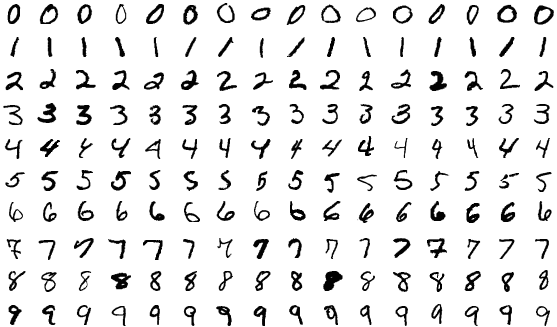


# Overview of dimensionality reduction methods

There are many dimensionality reduction methods that can be used with different types of data for different requirements.

[Dimensionality reduction methods](https://en.wikipedia.org/wiki/Dimensionality_reduction) are transformations of data from a high dimensional space into a low dimensional space such that the low dimensional representation retains meaningful properties of the original data, ideally close to its intrinsic dimension. These can be of two types: linear and nonlinear.

* [Linear methods](https://en.wikipedia.org/wiki/Dimensionality_reduction) involve linearly projecting the data into the low dimensional space
  - PCA ([Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis))
    - extracts a set of principal components that explain as much variation in the dataset as possible
    - unsupervised algorithm, as PCA does not require access to the labels
  - LDA ([Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis))
    - computes linear discriminants, directions that serve as axes that maximize separation between multiple classes
    - as such, it is a supervised learning algorithm because it requires access to the labels
  - Truncated SVD ([Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)) <br>
  - [Factor Analysis](https://en.wikipedia.org/wiki/Factor_analysis)
    - describes variability in the observed variables in terms of a potentially smaller number of unobserved latent variables

* [Non-linear methods](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) project high-dimensional data onto lower-dimensional latent manifolds, with the goal of either visualizing the data in the low-dimensional space, or learning the mapping (either from the high-dimensional space to the low-dimensional embedding or vice versa) itself:
  - t-SNE ([t-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding))
    - probabilistic
    - converts similarities between data points to a joint probability and attempts to minimize the Kullback-Leibler divergence between the joint probabilities of the high dimensional data and the low dimensional embedding
    - used for data visualization
    - if the number of features exceeds 50, PCA or Truncated SVD should be run first to reduce the computational requirements of running t-SNE
    - does not preserve densities/distances well, so it is not recommended as a preprocessing step before machine learning algorithms
  - [Kernel PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis)
    - uses a kernel function to project the data to a higher dimensional feature space where the data is linearly separable, and then uses PCA in that higher space to project the data into a lower dimensional space

# Loading and Examining the Palmer Penguins Dataset

Most of the examples today will use the Palmer penguins dataset. Let's import it and take a look at the contents.

In [86]:
# Import initial libraries
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [87]:
# Read the penguins dataset
filename = "https://raw.githubusercontent.com/clizarraga-UAD7/Datasets/main/penguins/penguins_size.csv"

df_dist = pd.read_csv(filename)

df_dist.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [88]:
df_dist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [89]:
# Drop rows with missing numbers
df = df_dist.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [90]:
df[['species', 'island']].value_counts()

species    island   
Gentoo     Biscoe       120
Chinstrap  Dream         68
Adelie     Dream         55
           Torgersen     47
           Biscoe        44
dtype: int64

Now at this point before performing any analysis, we can do some basic data exploration by looking at plots for all possible pairs of features.

If we were trying to develop a classifier for penguin species, and we found a pair of features where the penguin groups were nicely spaced apart, we could try developing a classifier on that feature pair and test the accuracy on some held out test data. As we can see below, many of the the feature pairs show significant overlap between the penguin populations, which would motivate us to try some dimensionality reduction techniques instead.

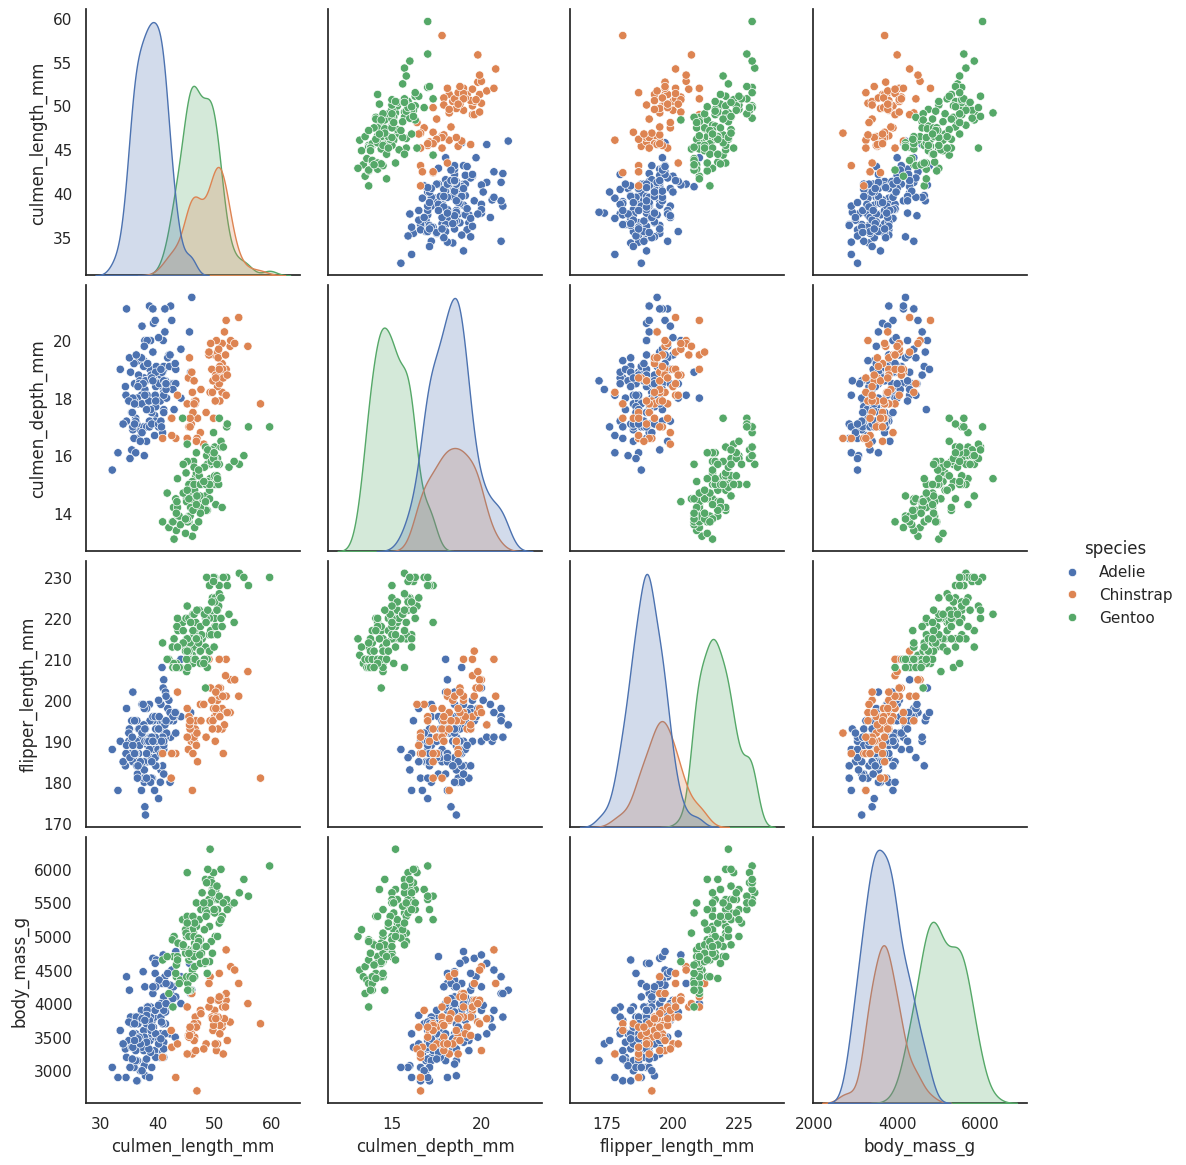

In [91]:
# See a pair plot for different variables
pairplot_figure = sns.pairplot(df, hue="species")
pairplot_figure.fig.set_size_inches(12, 12)

# Principal Component Analysis

PCA picks out a set of orthonormal vectors (vectors which are mutually 90 degrees from each other) that point in the direction that explains the most variance.

The first principal component is the best-fitting line which minimizes the average squared distance from all data points to the line, known as the mean squared error. The second principal component is the best-fitting line which minimizes the remaining MSE and is normal to the first principal component, and so on These principal components are linear combinations of the features in the data.

After these principal components have been computed, the data can be projected into a lower dimensional space using the top K components, where these K components represent some percentage of the total variation within the data.

[Read more...](https://en.wikipedia.org/wiki/Principal_component_analysis)

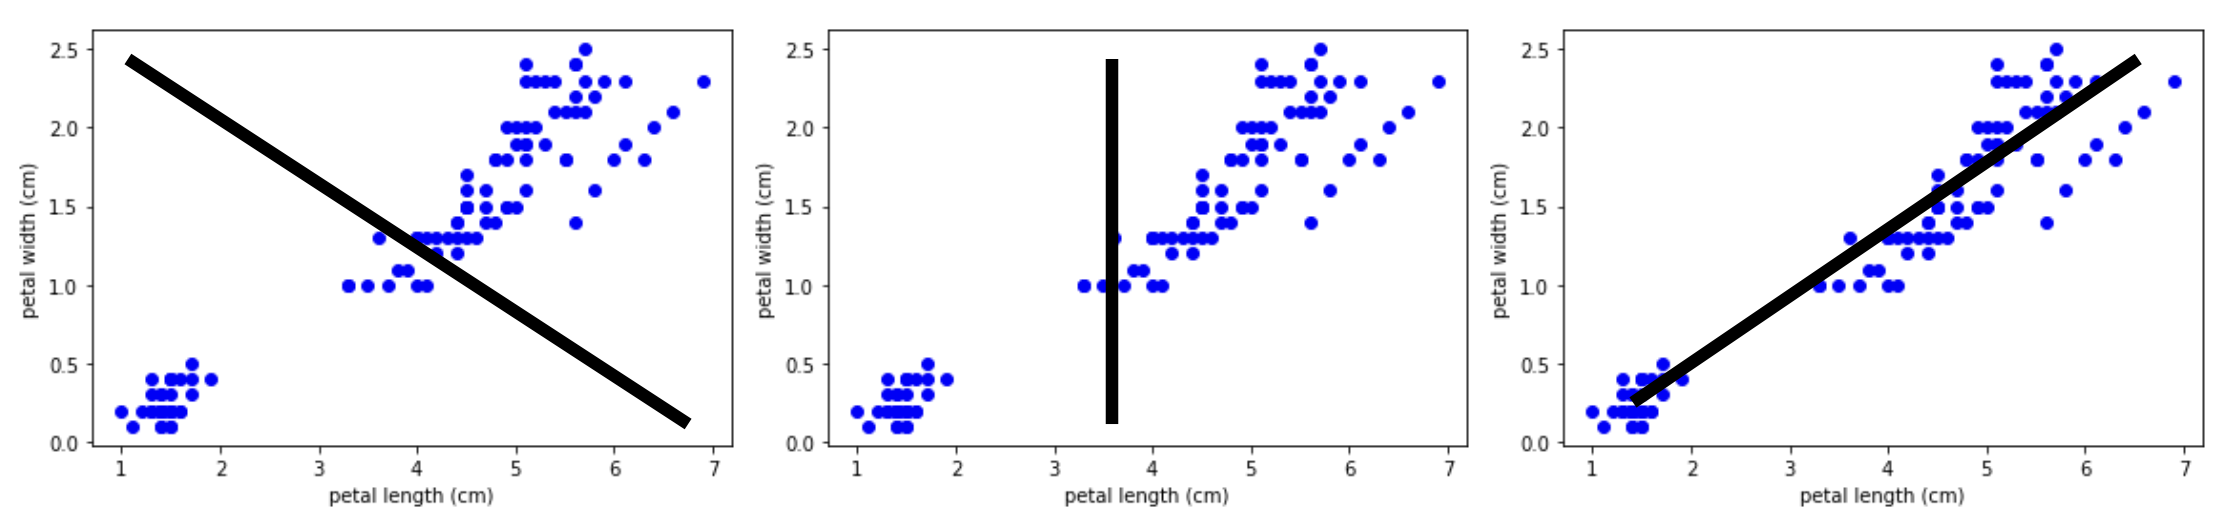

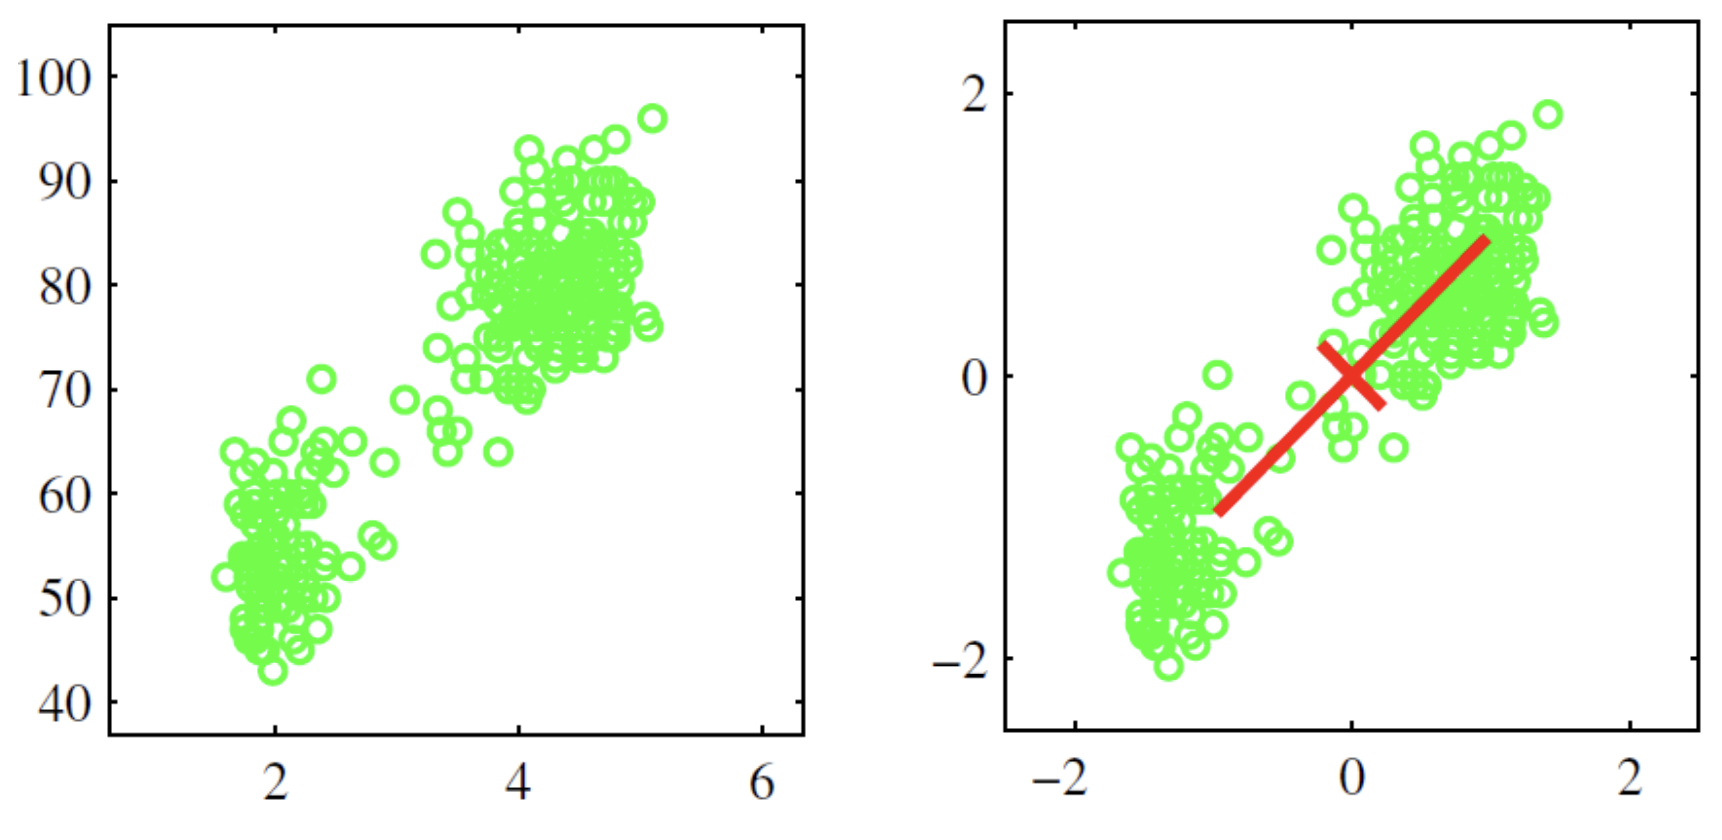

Source: Bishop, C.

## Correlation Matrix

It turns out that attempting to derive the principal components is the exact same task as finding the eigenvalues and eigenvectors of the correlation matrix.

[link to the magic]

From the correlation matrix, we can see that there are high cross correlations, thus we expect that PCA will perform well. If there is not significant cross correlation between values, then the features themselves are already in a sense the principal components, and cannot be reduced.

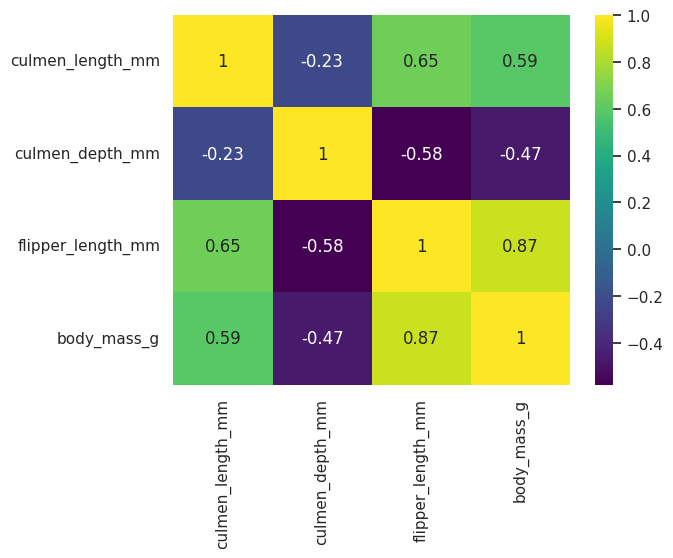

In [92]:
# Correlation map
sns.heatmap(df.corr(), cmap="viridis", annot=True)
plt.show()

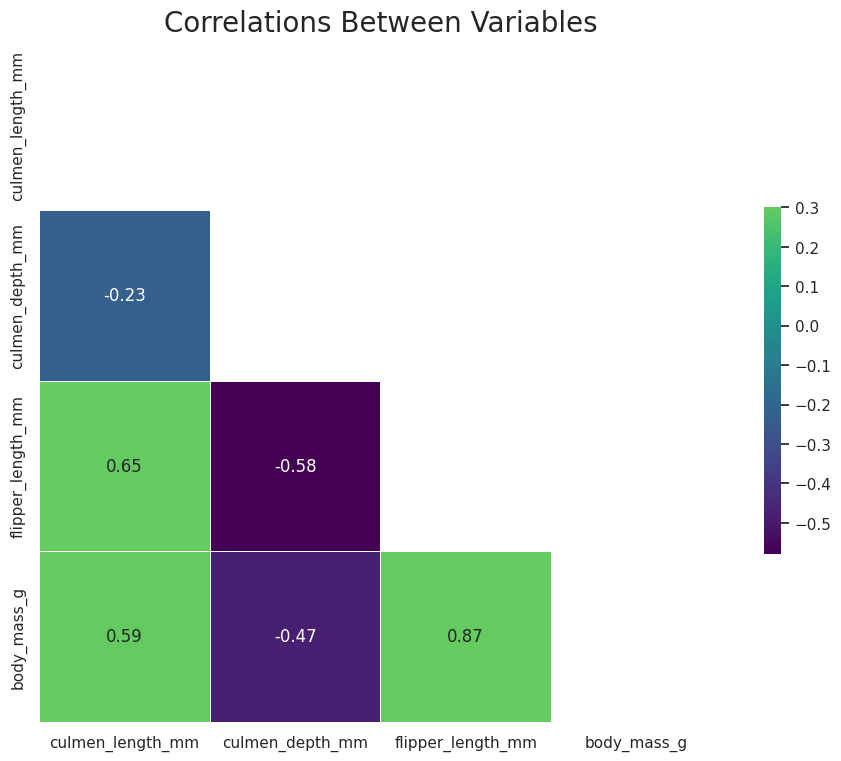

In [93]:
# Print the lower triangular part of correlation matrix
sns.set_theme(style="white")

corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(
    corr,
    mask=mask,
    cmap="viridis",
    annot=True,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

plt.title("Correlations Between Variables", size=20)
plt.show();


In the above matrix, we see that there are are large positive and negative correlations between many variables. This indicates that PCA will perform well.

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df_numeric = df.select_dtypes(include=[np.number])
x = StandardScaler().fit_transform(df_numeric)

pca = PCA()
x_PCA = pca.fit_transform(x)
x_PCA = pd.DataFrame(x_PCA)
print('x_PCA shape', x_PCA.shape)

# Print first 5 rows of the transformed data
x_PCA.head()


x_PCA shape (334, 4)


,0,1,2,3
0,-1.858488,0.031676,-0.234510,0.528668
1,-1.320722,-0.443473,-0.025823,0.402273
2,-1.381688,-0.161086,0.189986,-0.528493
3,-1.890897,-0.014556,-0.629799,-0.472072
4,-1.925839,0.816179,-0.703351,-0.196043


In [95]:
# Look at the principal components / eigenvectors of the covariance matrix

pc_df = pd.DataFrame(pca.components_[:4], columns = df_numeric.columns,
                     index = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3', 'Principal Component 4' ])
pc_df


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
Principal Component 1,0.453302,-0.399539,0.576782,0.549735
Principal Component 2,0.602018,0.794851,0.005121,0.075898
Principal Component 3,0.641365,-0.427790,-0.236911,-0.591203
Principal Component 4,0.144023,-0.159930,-0.781773,0.585244


In [96]:
# Look at the eigenvalues for the covariance matrix

print("The eigenvalues for the Covariance Matrix are:",
      list(np.round(pca.explained_variance_, decimals=3)), end='\n \n')


The eigenvalues for the Covariance Matrix are: [2.754, 0.78, 0.37, 0.108]
 


In [97]:
# See how much influence each variable has

print('Percent Explained variance ratio:\n', np.round(100.0*pca.explained_variance_ratio_, decimals=2))


Percent Explained variance ratio:
 [68.64 19.45  9.22  2.69]


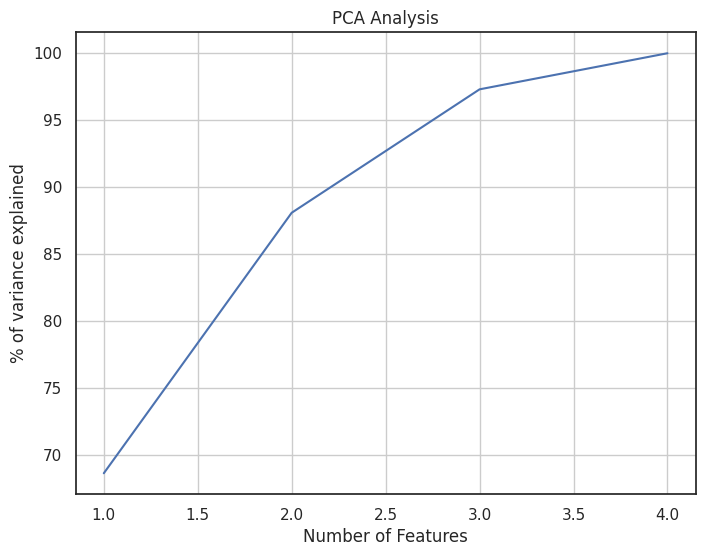

In [98]:
# Plot the variance explained by each component
n_pca = list(range(1,5))
out_sum = np.cumsum(pca.explained_variance_ratio_)*100.0

plt.figure(figsize=(8,6))
plt.plot(n_pca, out_sum)
plt.title('PCA Analysis')
plt.xlabel('Number of Features')
plt.ylabel('% of variance explained')
plt.grid(True)
plt.show();


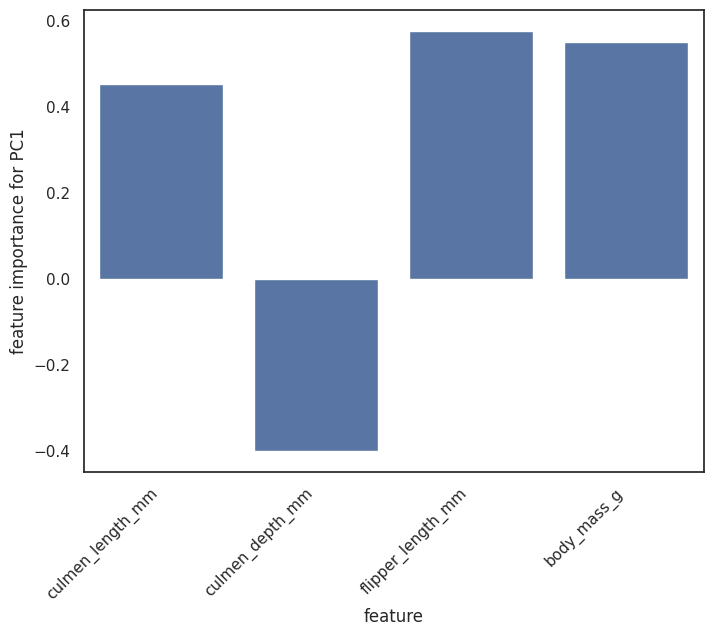

In [99]:
# Plot feature importance for PC1

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=pc_df.columns.values, y=pc_df.iloc[0].values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('feature')
ax.set_ylabel('feature importance for PC1')
plt.show();


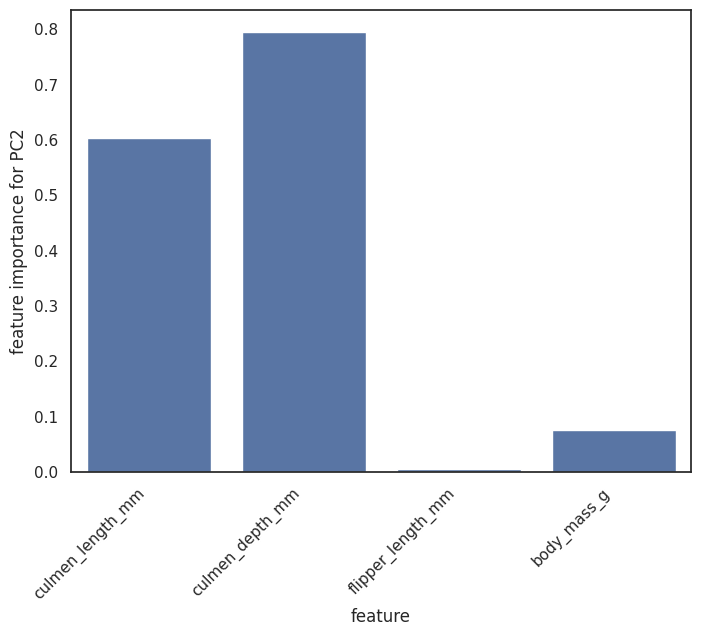

In [100]:
# Plot feature importance for PC2

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=pc_df.columns.values, y=pc_df.iloc[1].values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('feature')
ax.set_ylabel('feature importance for PC2')
plt.show();


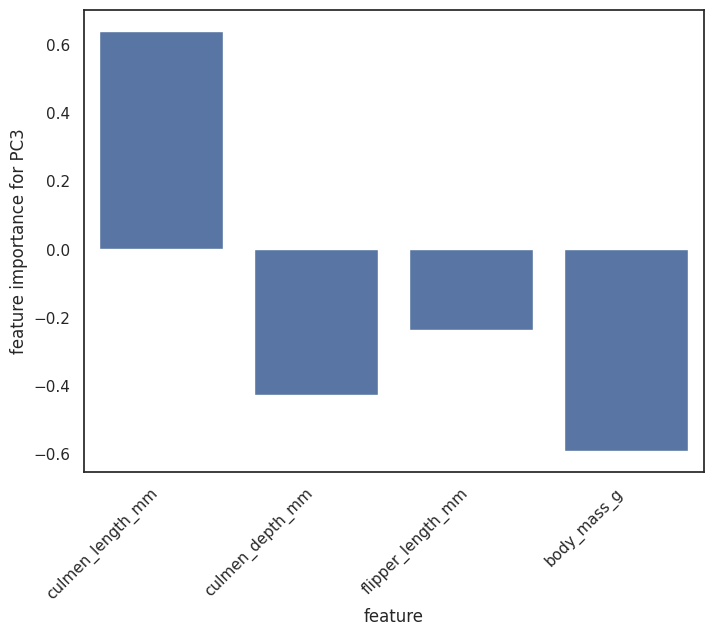

In [101]:
# Plot feature importance for PC2

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=pc_df.columns.values, y=pc_df.iloc[2].values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel('feature')
ax.set_ylabel('feature importance for PC3')
plt.show();

In [102]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Principal Component 1 to Principal Component 4
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   4 non-null      float64
 1   culmen_depth_mm    4 non-null      float64
 2   flipper_length_mm  4 non-null      float64
 3   body_mass_g        4 non-null      float64
dtypes: float64(4)
memory usage: 160.0+ bytes


In [103]:
# Separate dimensions and species
size_columns = ["flipper_length_mm", "culmen_depth_mm"]
target_column = "species"


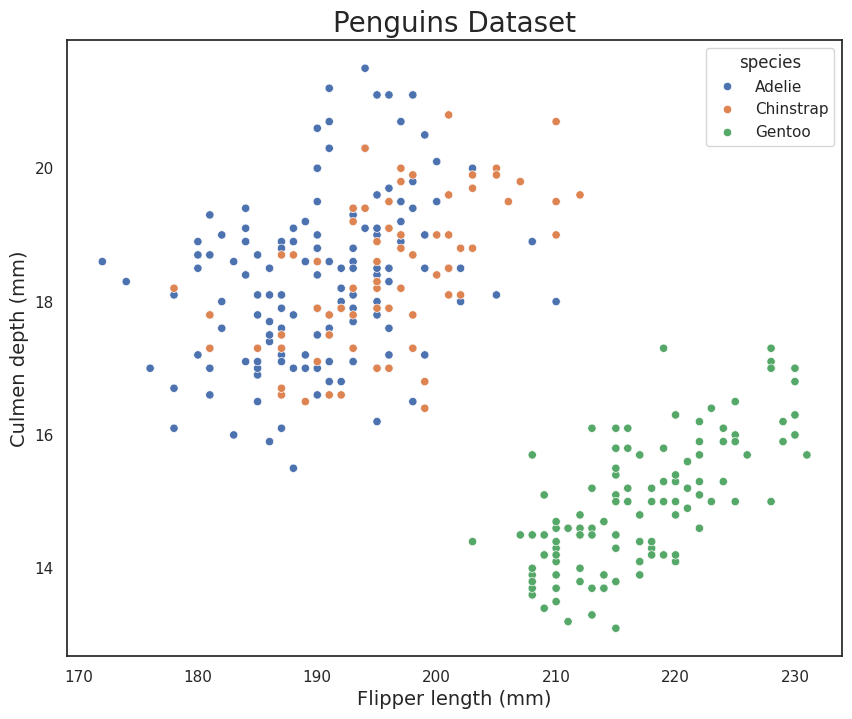

In [104]:
# Draw a scatterplot using the original data

plt.figure(figsize=(10,8))

x = df['flipper_length_mm'].values
y = df['culmen_depth_mm'].values
color = df['species']

sns.scatterplot(x=x,y=y,hue=color)
plt.title('Penguins Dataset',fontsize=20)
plt.xlabel('Flipper length (mm)',fontsize=14)
plt.ylabel('Culmen depth (mm)',fontsize=14)
plt.show()


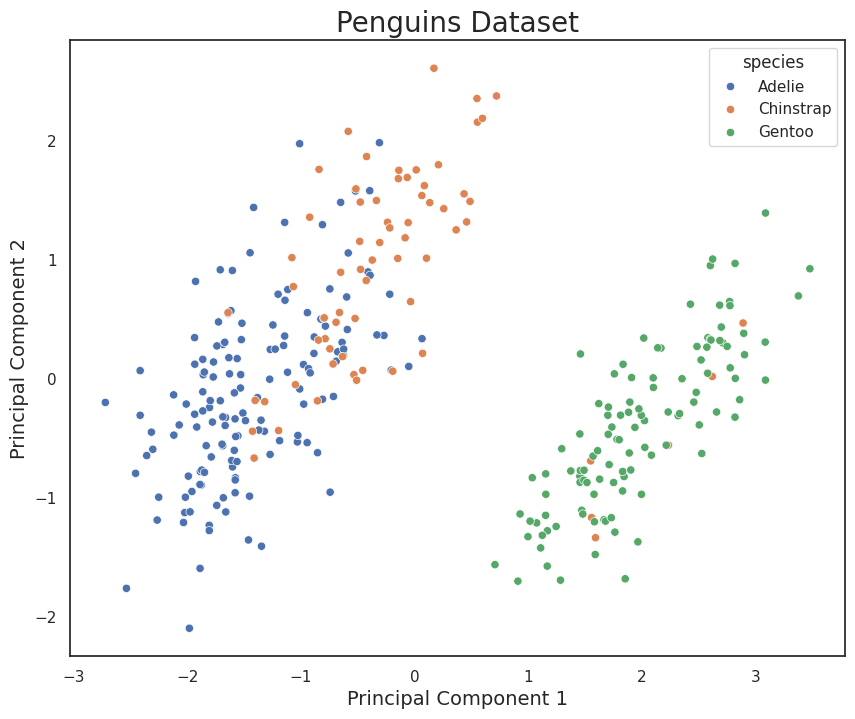

In [105]:
# Draw a scatterplot of the data projected using the principal components

plt.figure(figsize=(10,8))

x = x_PCA[0]
y = x_PCA[1]
color = df['species']

sns.scatterplot(x=x,y=y,hue=color)
plt.title('Penguins Dataset',fontsize=20)
plt.xlabel('Principal Component 1',fontsize=14)
plt.ylabel('Principal Component 2',fontsize=14)
plt.show()


We can recall that 68.64% of the variance is explained by PC1 and 19.45% by PC2. Thus, using only two principal components, we can capture approximately 88% of the variance in the penguins data.


## Additional PCA Example on MNIST

In [178]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', parser='pandas', as_frame=True)

In [179]:
mnist.frame.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [180]:
mnist.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 785 entries, pixel1 to class
dtypes: category(1), int64(784)
memory usage: 418.8 MB


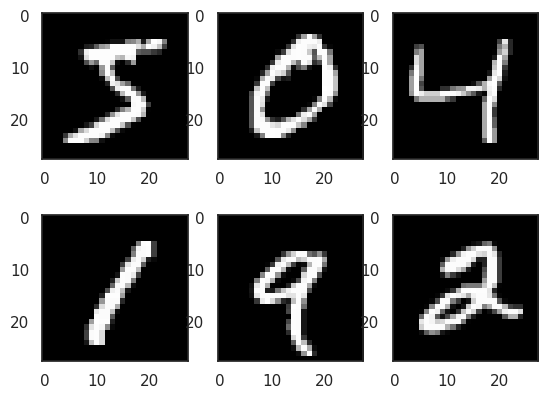

In [181]:
# Visualize the data

mnist_vectors = mnist.frame.select_dtypes(include=[np.number])
image = mnist_vectors.to_numpy()

for index in range(6):
    plt.subplot(2, 3, index+1)
    plt.imshow((image[index].reshape(28,28)), cmap='gray',
               interpolation='nearest')

In [201]:
# Create a smaller dataset of only 3 and 8s
np.random.default_rng(seed=0)

threes = mnist_vectors[mnist.frame['class'] == '3']
threes = threes.to_numpy()
np.random.shuffle(threes)

eights = mnist_vectors[mnist.frame['class'] == '8']
eights = eights.to_numpy()
np.random.shuffle(eights)

x = np.concatenate((threes[:200], eights[:200]), axis=0)
x.shape

(400, 784)

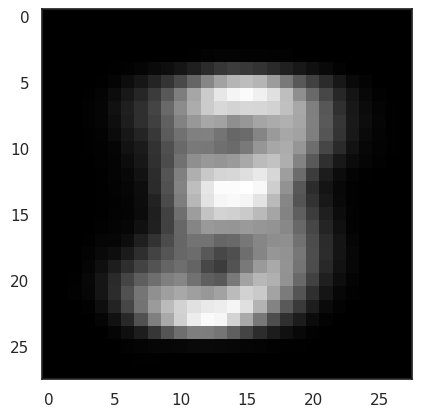

In [202]:
# Visualize the mean image in the remaining dataset of 400 images

x_bar = np.mean(x, axis=0)

plt.imshow(np.reshape(x_bar, (28, 28)), cmap='gray')

[[ 9.05044694e-19  2.61505373e-18]
 [-1.60512325e-18 -5.36621448e-18]
 [-2.57491933e-19 -1.32193408e-18]
 ...
 [-1.26005067e-18 -5.20011369e-18]
 [ 1.31870721e-18  4.67409996e-18]
 [ 7.17620579e-19  2.45418756e-18]]


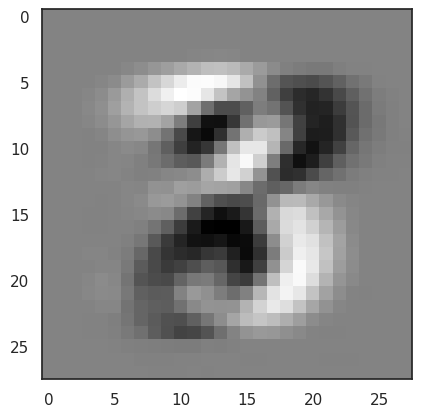

In [203]:
import scipy.sparse.linalg as linalg

# calculate the covariance
X = x - x_bar
S = np.matmul(X.T, X) / (np.shape(X)[0])

# using the covariance, calculate the eigenvectors/eigenvalues
vals, V = linalg.eigs(S, k=2, which='LM')
V = V.real
print(V)
eigval1 = vals[0].real
eigval2 = vals[1].real
eigvec1 = V[:,0]
eigvec2 = V[:,1]

# display the first eigenvector
plt.imshow(np.reshape(eigvec1, (28, 28)), cmap='gray')

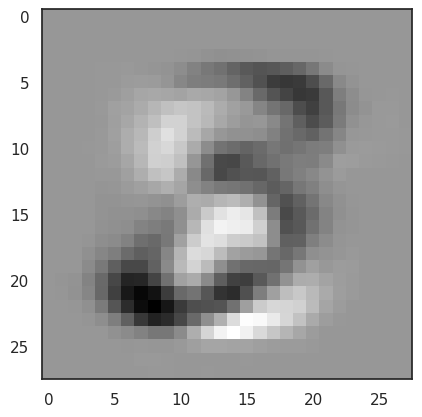

In [204]:
plt.imshow(np.reshape(eigvec2, (28, 28)), cmap='gray')

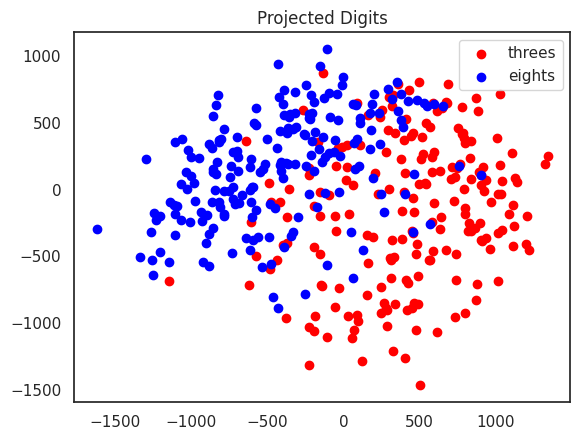

In [205]:
P = np.matmul(X, V)

plt.scatter(P[:200,0], P[:200,1], c=[1,0,0], label='threes')
plt.scatter(P[200:,0], P[200:,1], c=[0,0,1], label='eights')
plt.title('Projected Digits')
plt.legend()

This simple PCA method has also been used for [facial recognition](https://en.wikipedia.org/wiki/Eigenface). Given a training set of images of faces, a set of eigenvectors can be extracted from which the images in the training set can be reconstructed.

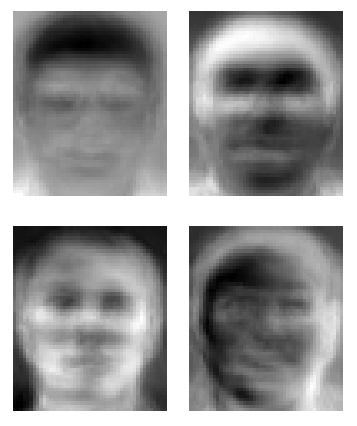

# Linear Discriminant Analysis

LDA is typically used for multi-class classification, but it can also be used as a dimensionality reduction technique. LDA best separates or discriminates (hence the name LDA) training instances by their classes. The major difference between LDA and PCA is that LDA finds a linear combination of input features that optimizes class separability while PCA attempts to find a set of uncorrelated components of maximum variance in a dataset. Another key difference between the two is that PCA is an unsupervised algorithm whereas LDA is a supervised algorithm where it takes class labels into account.


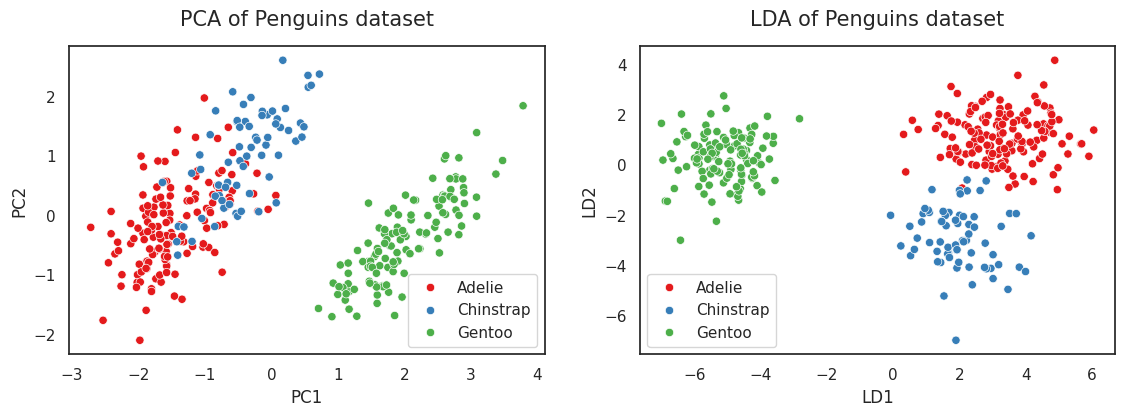

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


X = df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]].values
y = df['species'].values

# standardize features by setting the mean to the origin and scaling to unit variance
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# fit PCA model and transform the data
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# fit LDA model and transform the data
# https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
lda = LinearDiscriminantAnalysis(n_components=2, solver='svd')
X_lda = lda.fit_transform(X, y)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5 ,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(x=X_lda[:,0], y=X_lda[:,1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("PCA of Penguins dataset", fontsize=15, pad=15)
ax[1].set_title("LDA of Penguins dataset", fontsize=15, pad=15)
ax[0].set_xlabel("PC1", fontsize=12)
ax[0].set_ylabel("PC2", fontsize=12)
ax[1].set_xlabel("LD1", fontsize=12)
ax[1].set_ylabel("LD2", fontsize=12)
plt.show();


# Truncated Singular Value Decomposition (SVD)
This method performs linear dimensionality reduction by means of truncated singular value decomposition (SVD).

It works well with sparse data in which many of the row values are zero. In contrast, PCA works well with dense data. Truncated SVD can also be used with dense data.

Another key difference between truncated SVD and PCA is that factorization for SVD is done on the data matrix while factorization for PCA is done on the covariance matrix.

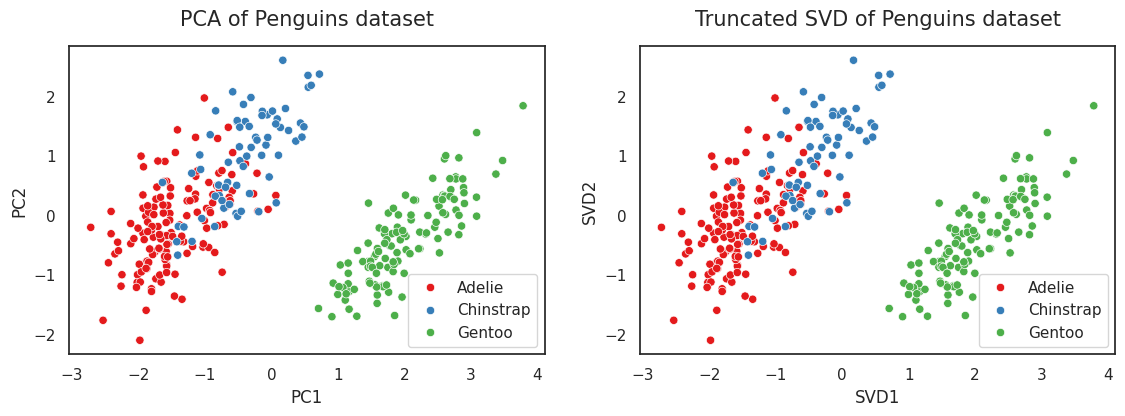

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA


X = df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]].values
y = df['species'].values

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# fit TruncatedSVD and transform data
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
svd = TruncatedSVD(n_components=2, algorithm='randomized',
                   random_state=0)
X_svd = svd.fit_transform(X_scaled)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5 ,4))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(x=X_svd[:,0], y=X_svd[:,1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("PCA of Penguins dataset", fontsize=15, pad=15)
ax[1].set_title("Truncated SVD of Penguins dataset", fontsize=15, pad=15)
ax[0].set_xlabel("PC1", fontsize=12)
ax[0].set_ylabel("PC2", fontsize=12)
ax[1].set_xlabel("SVD1", fontsize=12)
ax[1].set_ylabel("SVD2", fontsize=12)
plt.show();


# Kernel PCA

The code for this example is taken from the scikit-learn documentation.


In [108]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1_000, factor=0.3, noise=0.05, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

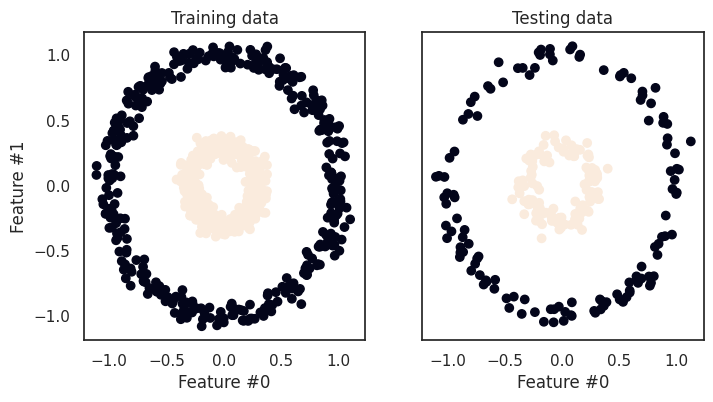

In [109]:
import matplotlib.pyplot as plt

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [110]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=2)

# KPCA uses a linear kernel by default. Here, we request an radial basis function kernel instead.
# This is commonly used in kernel methods.
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_test_pca = pca.fit(X_train).transform(X_test)
X_test_kernel_pca = kernel_pca.fit(X_train).transform(X_test)

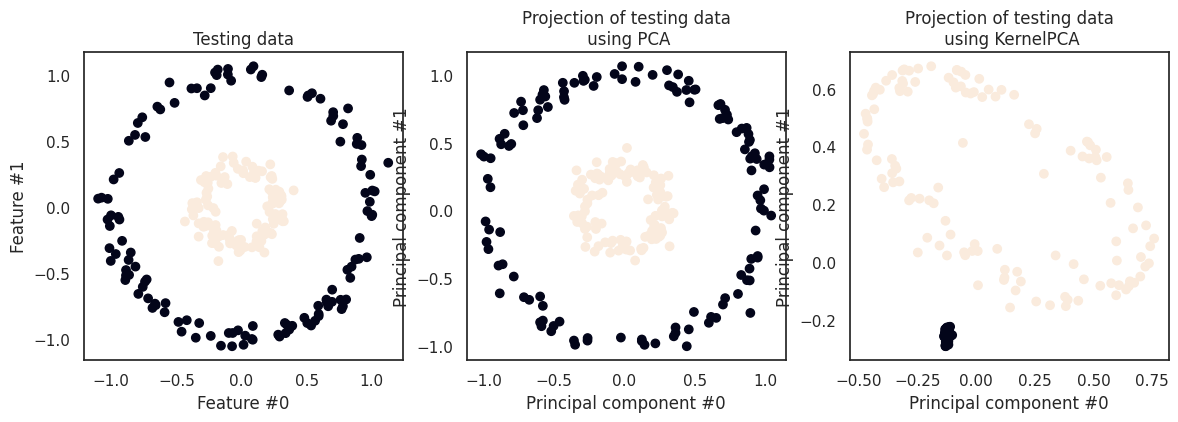

In [111]:
fig, (orig_data_ax, pca_proj_ax, kernel_pca_proj_ax) = plt.subplots(
    ncols=3, figsize=(14, 4)
)

orig_data_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
orig_data_ax.set_ylabel("Feature #1")
orig_data_ax.set_xlabel("Feature #0")
orig_data_ax.set_title("Testing data")

pca_proj_ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test)
pca_proj_ax.set_ylabel("Principal component #1")
pca_proj_ax.set_xlabel("Principal component #0")
pca_proj_ax.set_title("Projection of testing data\n using PCA")

kernel_pca_proj_ax.scatter(X_test_kernel_pca[:, 0], X_test_kernel_pca[:, 1], c=y_test)
kernel_pca_proj_ax.set_ylabel("Principal component #1")
kernel_pca_proj_ax.set_xlabel("Principal component #0")
_ = kernel_pca_proj_ax.set_title("Projection of testing data\n using KernelPCA")

# t-distributed Stochastic Neighbor Embedding (t-SNE)

This is also a non-linear dimensionality reduction method mostly used for data visualization.

In addition to that, it is widely used in image processing and NLP.

The Scikit-learn documentation recommends you to use PCA or Truncated SVD before t-SNE if the number of features in the dataset is more than 50.

The following is the general syntax to perform t-SNE after PCA. Also, note that feature scaling is required before PCA.


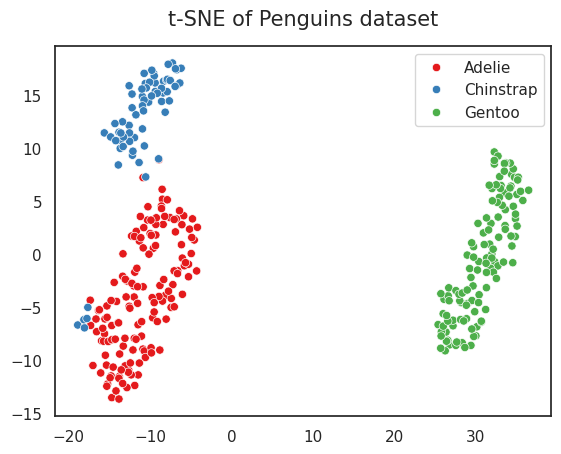

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


X = df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm", "body_mass_g"]].values
y = df['species'].values

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
tsne = TSNE(n_components=2, random_state=1)
X_tsne = tsne.fit_transform(X_scaled)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='Set1')
plt.title("t-SNE of Penguins dataset", fontsize=15, pad=15)
plt.show();
